In [1]:
import numpy as np
import scipy.integrate as integrate
import pandas as pd

import datetime

from astroquery.jplhorizons import Horizons

import plotly.graph_objects as go

# Simulation Setup

In [76]:
## Useful constants
G = 6.67428e-11
m_earth = 5.97219e24
m_sun = 1.9891e30
au = 149597870700 # 1 Astronomical unit in meters: https://cneos.jpl.nasa.gov/glossary/au.html
seconds_in_year = 1*365.25*24*60*60

# Table with parameters for each body
body_names  = ["Sun", "Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "Pluto"]
body_ids    = [10, 199, 299, 399, 499, 599, 699, 799, 899, 999]
body_sim_colors = [
    "lemonchiffon",  # Sun
    "gray",     # Mercury
    "gold",          # Venus
    "lightseagreen", # Earth
    "coral",         # Mars
    "orange",        # Jupiter
    "sandybrown",    # Saturn
    "paleturquoise", # Uranus
    "skyblue",       # Neptune
    "gray"           # Pluto
]

body_hrzn_colors = [
    # Colors for plotting horizons data (groundtruth)
    "yellow",       # Sun
    "darkgray",     # Mercury
    "goldenrod",    # Venus
    "darkseagreen", # Earth
    "darksalmon",   # Mars
    "darkorange",   # Jupiter
    "peru",         # Saturn
    "turquoise",    # Uranus
    "deepskyblue",  # Neptune
    "slategray"     # Pluto
]

body_masses = [
    # Manually retrieved from Horizons:
    1.9891e30,      # Sun
    3.302e23,       # Mercury
    48.685e23,      # Venus
    5.97219e24,     # Earth
    6.4171e23,      # Mars
    189818722e22,   # Jupiter
    5.6832e26,      # Saturn
    86.813e24,      # Uranus
    102.409e24,     # Neptune
    1.307e22        # Pluto
]

# Create the dataframe with all the planetary information
df_bodies = pd.DataFrame({
    "name": body_names,
    "mass": body_masses,
    "NAIF_ID": body_ids,
    "sim_color": body_sim_colors,
    "hrzn_color": body_hrzn_colors
})

# Toggle if we want to only simulate planets within the asteroid belt, before Jupiter
ignore_far_planets = True
if ignore_far_planets:
    # Simply discrad Jupiter and all planets afterward.
    df_bodies = df_bodies.iloc[0:5]

In [78]:
## Pull data from Horizons

# Enter the desired simulation length
start_date = "2023-04-10"
sim_days = 365 * 2
sim_steps = int(sim_days/3)

# Create stop time string based on desired simulation length
datetime_format = "%Y-%m-%d"
start_datetime = datetime.datetime.strptime(start_date, datetime_format)
stop_datetime = start_datetime + datetime.timedelta(days=sim_days)
stop_date = stop_datetime.strftime(datetime_format)

def query_body_data(id):
    query = Horizons(id=id, location='500@0', epochs={"start": start_date, "stop": stop_date, "step": str(sim_steps - 1)})
    df = query.vectors().to_pandas()
    hrzns_pos = df[["x", "y", "z"]].to_numpy() * au    # Convert au to m
    hrzns_vel = df[["vx", "vy", "vz"]].to_numpy() * au / (24 * 60 * 60) # Convert au/d to m/s
    
    return hrzns_pos, hrzns_vel

bodies_pos = np.zeros((len(df_bodies.index), sim_steps, 3))
bodies_vel = np.zeros((len(df_bodies.index), sim_steps, 3))
for i, NAIF_ID in enumerate(df_bodies["NAIF_ID"]):
    pos, vel = query_body_data(NAIF_ID)
    bodies_pos[i, :, :] = pos
    bodies_vel[i, :, :] = vel

# Core Simulation

In [79]:
## Two-body problem
sim_earth_pos_0 = bodies_pos[1, 0, :]
sim_earth_vel_0 = bodies_vel[1, 0, :]

sim_mars_pos_0 = bodies_pos[2, 0, :]
sim_mars_vel_0 = bodies_vel[2, 0, :]

y_0 = np.concatenate([sim_earth_pos_0, sim_earth_vel_0])

n_bodies = len(df_bodies.index)
masses = df_bodies["mass"].to_numpy()

pos_0 = np.array([])
vel_0 = np.array([])
for i in df_bodies.index:
    pos_0 = np.append(pos_0, bodies_pos[i, 0, :])
    vel_0 = np.append(vel_0, bodies_vel[i, 0, :])

y_0 = np.concatenate([pos_0, vel_0])
    
def sun_earth_diffeq(t, y):
    dy = np.zeros(y.shape)    
    for i in df_bodies.index:
        pos_i = np.atleast_2d(y[3*i: 3*i + 3]).T
        pos_all = np.reshape(y[0:n_bodies*3], (n_bodies, 3)).T    # 3xn matrix where each column is the position of a body
        disp_all = pos_all - pos_i

        r_all = np.linalg.norm(disp_all, axis=0)
        accel_from_each = G * masses * r_all**-3 * disp_all
        accel_from_each = np.nan_to_num(accel_from_each)
        accel_i = np.sum(accel_from_each, axis=1)

        dy[3 * (n_bodies + i): 3 * (n_bodies + i + 1)] = accel_i
        
    # Propogate forward the velocities: xdot = v
    dy[0:n_bodies * 3] = y[3*n_bodies:6*n_bodies]
    
    return dy

n_days = sim_days
tspan = [0, n_days * 24 * 60 * 60]
n_points = sim_steps
t_eval = np.linspace(tspan[0], tspan[1], n_points)

sim_soln = integrate.solve_ivp(sun_earth_diffeq, tspan, y_0, t_eval=t_eval, atol=1e-4, rtol=1e-4)

/tmp/ipykernel_138225/2101180457.py:29: RuntimeWarning:

divide by zero encountered in power

/tmp/ipykernel_138225/2101180457.py:29: RuntimeWarning:

invalid value encountered in multiply



# Simulation Results

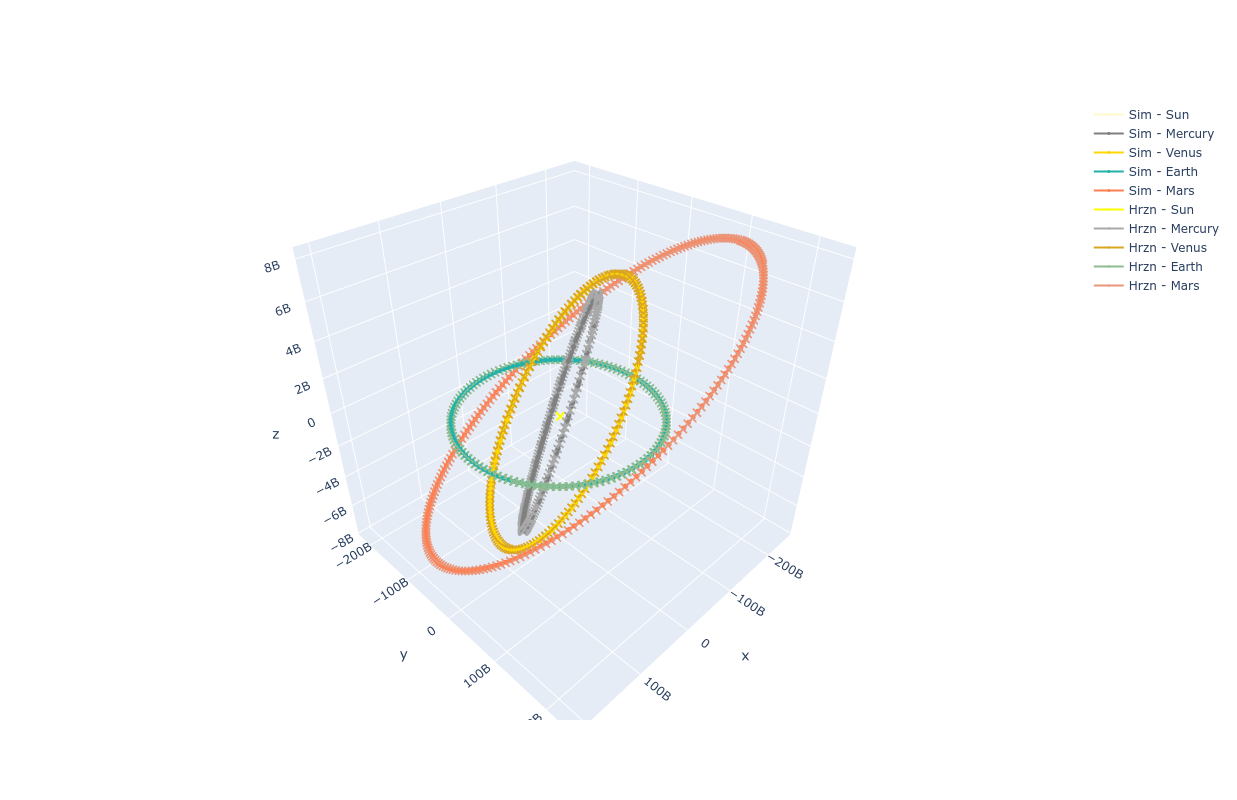

In [80]:
fig = go.Figure()

for i in df_bodies.index:
    body = df_bodies.iloc[i]
    
    fig.add_trace(go.Scatter3d(
        x=sim_soln.y[3*i, :],
        y=sim_soln.y[3*i+1, :],
        z=sim_soln.y[3*i+2, :],
        name=f"Sim - {body['name']}",
        mode="lines+markers",
        marker={"size": 3, "color": body["sim_color"]}
    ))

# Plot horizons ground truth trajectories here:
for i in df_bodies.index:
    body = df_bodies.iloc[i]
    
    fig.add_trace(go.Scatter3d(
        x=bodies_pos[i, :, 0],
        y=bodies_pos[i, :, 1],
        z=bodies_pos[i, :, 2],
        name=f"Hrzn - {body['name']}",
        mode="lines+markers",
        marker={"size": 2, "color": body["hrzn_color"], "symbol":"x"}
    ))

fig.update_layout(yaxis=dict(scaleanchor="x", scaleratio=1), width=1200, height=800)
fig.show()